In [1]:
import pandas as pd
import pandas as pd

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['Measurements', 'Stations']

In [4]:
Measurement = Base.classes.Measurements
Station = Base.classes.Stations

In [5]:
session = Session(engine)

-- Query 1: Precipitation

In [6]:
# Find the last year's precipitation data
query = session.query(Measurement.date, func.sum(Measurement.prcp)).group_by(Measurement.date).\
    order_by(Measurement.id.desc()).limit(365).all()

In [7]:
# Convert query into a DF and invert the dates
precip = pd.DataFrame(query, columns=['Date', 'Precipitation'])
precip = precip.sort_index(ascending=False)
precip = precip.reset_index()
precip = precip.drop("index", 1)
precip.head()

,Date,Precipitation
0,2016-07-10,2.43
1,2016-07-11,0.43
2,2016-07-12,0.11
3,2016-07-13,0.32
4,2016-07-14,2.76


In [8]:
# Import for charts
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Find label names for every 50 days to plot at reference for graph
ticks = np.arange(0, 400, 50)
ticks = ticks.tolist()
ticks

date_tick = []
for x in ticks:
    date = precip["Date"][x]
    date_tick.append(date)
    
date_tick

['2016-07-10',
 '2016-09-07',
 '2016-10-27',
 '2016-12-21',
 '2017-02-11',
 '2017-04-12',
 '2017-06-12',
 '2017-08-02']

In [10]:
# Reset DF index
precip = precip.set_index('Date')

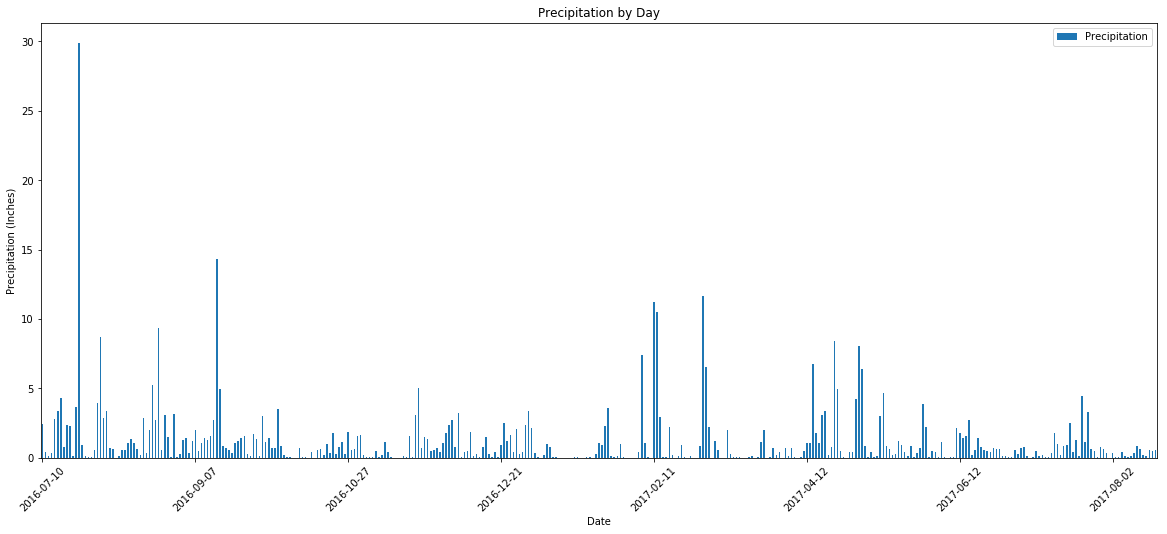

In [11]:
# Plot the DF
precip.plot(kind="bar", figsize=(20,8))
plt.xticks(ticks, date_tick, rotation=45)
plt.title("Precipitation by Day")
plt.ylabel("Precipitation (Inches)")
plt.savefig("Figures/Precipitation_by_day")
plt.show()

In [12]:
# Write the DF to a CSV for later use
precip.to_csv("Resources/PrecipDF.csv")

-- Query 2: Stations

In [13]:
# Number of Stations
Station_Count = session.query(func.count(Station.id)).all()
Station_Count

[(9)]

In [14]:
# Station Activity
Station_Activity = session.query(Station.station, Station.name, func.count(Measurement.date)). \
    filter(Station.station == Measurement.station).\
    group_by(Station.name).order_by(func.count(Measurement.date).desc()).all()

Station_Activity

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2696),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2685),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2572),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2484),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 1937),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1932),
 ('USC00517948', 'PEARL CITY, HI US', 683),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 342)]

In [15]:
highest = "USC00519281"

high_tobs = session.query(Measurement.date, Measurement.tobs).order_by(Measurement.id.desc()). \
    filter(Measurement.station == highest).limit(365).all()
    
high_tobs

[('2017-08-18', 79),
 ('2017-08-17', 76),
 ('2017-08-16', 76),
 ('2017-08-15', 77),
 ('2017-08-14', 77),
 ('2017-08-13', 77),
 ('2017-08-06', 83),
 ('2017-08-05', 82),
 ('2017-08-04', 77),
 ('2017-07-31', 76),
 ('2017-07-30', 81),
 ('2017-07-29', 82),
 ('2017-07-28', 81),
 ('2017-07-27', 76),
 ('2017-07-26', 75),
 ('2017-07-25', 77),
 ('2017-07-24', 75),
 ('2017-07-23', 82),
 ('2017-07-22', 77),
 ('2017-07-21', 77),
 ('2017-07-20', 77),
 ('2017-07-19', 76),
 ('2017-07-18', 76),
 ('2017-07-17', 76),
 ('2017-07-16', 80),
 ('2017-07-15', 80),
 ('2017-07-14', 76),
 ('2017-07-13', 74),
 ('2017-07-12', 74),
 ('2017-07-11', 72),
 ('2017-07-10', 69),
 ('2017-07-09', 78),
 ('2017-07-08', 78),
 ('2017-07-07', 75),
 ('2017-07-06', 74),
 ('2017-07-05', 77),
 ('2017-07-04', 78),
 ('2017-07-03', 76),
 ('2017-07-02', 81),
 ('2017-07-01', 79),
 ('2017-06-30', 76),
 ('2017-06-29', 76),
 ('2017-06-28', 77),
 ('2017-06-27', 76),
 ('2017-06-26', 73),
 ('2017-06-25', 71),
 ('2017-06-24', 77),
 ('2017-06-23

In [16]:
# Convert query into a DF
tobs = pd.DataFrame(high_tobs, columns=["Date", "Temp Obs"])
tobs.head()

,Date,Temp Obs
0,2017-08-18,79
1,2017-08-17,76
2,2017-08-16,76
3,2017-08-15,77
4,2017-08-14,77


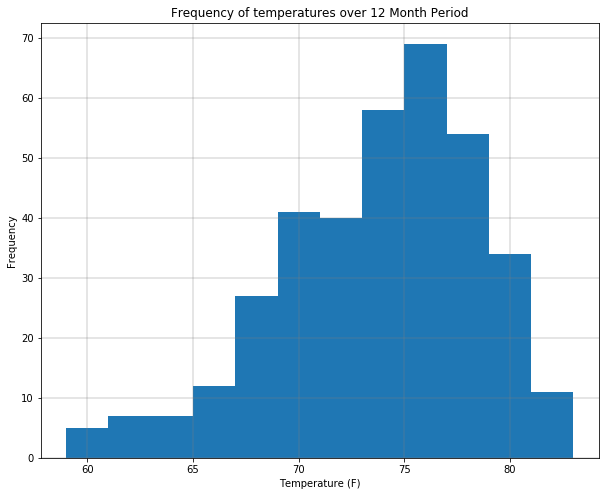

In [17]:
plt.figure(figsize=(10,8))
plt.hist(tobs["Temp Obs"], bins=12)
plt.grid(color='grey', linestyle='-', linewidth=2, alpha=.2)
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.title("Frequency of temperatures over 12 Month Period")
plt.savefig("Figures/TempHisto")
plt.show()

-- Query 3: Temperature

In [82]:
def calc_temp():
    SY = input("Trip Start, Year: (1991, 2001, ect) ")
    SM = input("Trip Start, Month: (01 as January, ect) ")
    SD = input("Trip Start, Day: (01, 02, ect) ")
    EY = input("Trip End, Year: ")
    EM = input("Trip End, Month: ")
    ED = input("Trip End, Day: ")

    SY_int = int(SY)
    SY_1 = SY_int - 1

    EY_int = int(EY)
    EY_1 = EY_int - 1

    start_date = str(SY_1) + "-" + SM + "-" + SD
    end_date = str(EY_1) + "-" + EM + "-" + ED

    min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date >= start_date). \
        filter(Measurement.date <= end_date).all()
    max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date >= start_date). \
        filter(Measurement.date <= end_date).all()
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date >= start_date). \
        filter(Measurement.date <= end_date).all()

    delta = int(max_temp[0][0] - min_temp[0][0])
    avg_temp = avg_temp[0][0]
    avg_temp = round(avg_temp, 2)

    chart_frame = pd.DataFrame({'average_temp': [avg_temp]})
    chart_frame.head()

    chart_frame.plot(kind="bar", figsize = (5,7), yerr=delta)
    plt.title("Average Temp from Previous Year")
    plt.ylim(0,int(max_temp[0][0] + 20))
    plt.ylabel("Temperature (F)")
    plt.xticks([])
    plt.savefig("Figures/YearPrevious")
    plt.show()

-- API Testing

In [83]:
#Start Flask application
from flask import Flask, jsonify
app = Flask(__name__)

In [ ]:
# A quick landing page for links

@app.route("/")
def links():
    return (
        "List of API calls for this website!</br>"
        "/api.v1.0/precipitation</br>"
        "/api/v1.0/stations</br>"
        "/api/v1.0/tobs</br>"
        "/api/v1.0/'start date as YYYY-MM-DD'</br>"
        "/api/v1.0/'start date as YYYY-MM-DD'/'end date as YYYY-MM-DD'</br>"
    )

if __name__ == '__main__':
    app.run(debug=True)

In [ ]:
# Returns the previous year's precipitation

@app.route("/api.v1.0/precipitation")
def precip():
    
    query = session.query(Measurement.date, func.sum(Measurement.prcp).label("prcp")). \
    group_by(Measurement.date).order_by(Measurement.id.desc()).limit(365).all()

    precipitation = []
    for rain_drop in query:
        drop_top = {}
        drop_top["Date"] = rain_drop.date
        drop_top["Total Precip"] = rain_drop.prcp
        precipitation.append(drop_top)

    return jsonify(precipitation)

if __name__ == '__main__':
    app.run(debug=True)

In [ ]:
# Returns the station informations

@app.route("/api/v1.0/stations")
def stations():

    stat = session.query(Station).all()
    
    station_info = []
    for looping in stat:
        blank_dict = {}
        blank_dict["Station"] = looping.station
        blank_dict["Name"] = looping.name
        blank_dict["Latitude"] = looping.latitude
        blank_dict["Longitude"] = looping.longitude
        blank_dict["Elevation"] = looping.elevation
        station_info.append(blank_dict)
    
    return jsonify(station_info)

if __name__ == '__main__':
    app.run(debug=True)

In [ ]:
# Temperature observed information

@app.route("/api/v1.0/tobs")
def tobs():
    
    query = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.date >= "2016-01-01"). \
        filter(Measurement.date < "2017-01-01").all()
   
    Bring = []
    for hot in query:
        the_heat = {}
        the_heat["Station ID"] = hot.station
        the_heat["Date"] = hot.date
        the_heat["Temp Observed"] = hot.tobs
        Bring.append(the_heat)
    
    return jsonify(Bring)

if __name__ == '__main__':
    app.run(debug=True)

In [ ]:
# Temperatre fom a start date

@app.route("/api/v1.0/<start>")
def temps(start='2016-01-01'):
    
    min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date >= start).all()
    max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date >= start).all()
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date >= start).all()
    
    min_temp_str = str(min_temp[0][0])
    max_temp_str = str(max_temp[0][0])
    avg_temp_str = str(avg_temp[0][0])
    
    Temps = [{
            'Min Temp': min_temp_str,
            'Max Temp': max_temp_str,
            'Average Temp': avg_temp_str
    }]
    
    return jsonify(Temps)

if __name__ == '__main__':
    app.run(debug=True)

In [ ]:
# Temperature from a date range

@app.route("/api/v1.0/<start>/<end>")
def temps(start='', end=''):
    
    min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date >= start).\
            filter(Measurement.date <= end).all()
    max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date >= start).\
            filter(Measurement.date <= end).all()
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date >= start).\
            filter(Measurement.date <= end).all()
    
    min_temp_str = str(min_temp[0][0])
    max_temp_str = str(max_temp[0][0])
    avg_temp_str = str(avg_temp[0][0])
    
    Temps = [{
            'Min Temp': min_temp_str,
            'Max Temp': max_temp_str,
            'Average Temp': avg_temp_str
    }]
    
    return jsonify(Temps)

if __name__ == '__main__':
    app.run(debug=True)